# Chapter 13 - Causality and Large Language Models

The notebook is a code companion to chapter 13 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%2013/Chapter_13_Causality_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written with the following libraries and versions.

In [2]:
!pip install dowhy==0.11
!pip install transformers==4.38.2
!pip install accelerate==0.28.0
!pip install pandas==2.0.3
!pip install numpy==1.25.2
!pip install pyro-ppl==1.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.7/377.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

## Listing 13.1: DoWhy code generated by ChatGPT (verbatim)

Modern LLMs are trained on a vast corpora of code from a wide variety of programming languages. You can ask the LLM to generate code from libraries that are represented in the training data. For example, we can prompt ChatGPT to implement a lung cancer DAG in DoWhy and estimate the causal effect.

> **User**: Provide me with code that uses the DoWhy library in Python to implement the causal DAG that you suggested above. Include cigarette price as an instrumental variable and provide code for estimating the causal effect.

> **ChatGPT**: Certainly! Here’s a basic example using the DoWhy library in Python for implementing the causal DAG for the relationship between smoking and lung cancer, using cigarette price as an instrumental variable.

This is the verbatim code ChatGPT generated.

In [3]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
from dowhy.datasets import linear_dataset

# Let's create a sample dataset for illustration purposes
# Normally, you'd import your own dataset: data = pd.read_csv('your_dataset.csv')
n_points = 1000
data = pd.DataFrame({
    "S": np.random.binomial(n=1, p=0.5, size=n_points),  # 0 for non-smoker, 1 for smoker
    "LC": np.random.binomial(n=1, p=0.5, size=n_points),  # 0 for no lung cancer, 1 for lung cancer
    "Price": np.random.normal(loc=5, scale=1, size=n_points),  # Example cigarette price
})

# Create a causal DAG
model=CausalModel(
        data = data,
        treatment='S',
        outcome='LC',
        common_causes=['G', 'A', 'E', 'O'],  # Potential confounders
        instruments=['Price']  # Instrumental Variable
)

# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the causal effect using Instrumental Variable method
estimate = model.estimate_effect(identified_estimand,
                                 method_name="iv.instrumental_variable",
                                 method_params={'iv_instrument_name': 'Price'})

# Print the causal effect estimate
print(estimate)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_model.py:559: UserWarning: 4 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                            -1⎤
 ⎢   d         ⎛   d         ⎞  ⎥
E⎢────────(LC)⋅⎜────────([S])⎟  ⎥
 ⎣d[Price]     ⎝d[Price]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→LC then ¬(U →→{Price})
Estimand assumption 2, Exclusion: If we remove {Price}→{S}, then ¬({Price}→LC)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡  d       ⎤  -1⎡  d      ⎤
E⎢──────(LC)⎥⋅E  ⎢──────(S)⎥
 ⎣dPrice    ⎦    ⎣dPrice   ⎦
Estimand assumption 1, As-if-random: If U→→LC then ¬(U →→{Price})
Estimand assumption 2, Exclusion: If we remove {Price}→{S}, then ¬({Price}→LC)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['S'] is affected in the same way by common causes of ['S'] and ['LC']
Estimand assumption 4, outcome_effect_homogeneity: Each un

## Listing 13.2: Viewing example tokens than an LLM operates upon

In the context of LLMs, a "token" refers to a sequence of characters that the model reads. A token can be as short as one character or as long as one word. Tokens are the units into which input text is divided into manageable pieces for the model.

Huggingface's Transformers library has a publicly available version of GPT-2, which is far inferior to cutting-edge models, but has a similar Transformer architecture. Let's tokenize the expression “Can LLMs reason counterfactually?”

In [4]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')    #A
tokens = tokenizer.tokenize("Can LLMs reason counterfactually?") #B
print(tokens)    #C
#A Initialize the GPT-2 tokenizer
#B Tokenize the sequence
#C Print out the tokens

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

['Can', 'ĠLL', 'Ms', 'Ġreason', 'Ġcounter', 'fact', 'ually', '?']


The “Ġ” corresponds to a space. Note that punctuations are tokens, and that words like “counterfactual” are broken up into multiple tokens.

# Listing 13.3 Coverting tokens to integers
Each token corresponds to an integer indexing the token in a large “vocabulary”. GPT-2 has a vocabulary size of 50,257.


In [5]:
input_ids = tokenizer.encode(    #A
    "Can LLMs reason counterfactually?",    #A
    return_tensors='pt'    #A
)    #A
print(input_ids)
#A "Encode" the tokens into integers that index the token in a list of tokens called the "vocabulary"

tensor([[ 6090, 27140, 10128,  1738,  3753, 22584,   935,    30]])


## Listing 13.4: Calculate the log-probability of each token in the sequence

LLMs define a joint probability distribution on sequences of tokens. For the phrase “Can LLMs reason counterfactually?”, the model defines a probability distribution:

$P(X_0 = “Can”, X_1=“LL”, X_2=“Ms”, X_3=“reason”, …, X_7 = “?”)$

The models also consider the chances that this sequence ended at the question mark, rather than continuing. For that, the LLM's vocabulary includes a special token to mark the end of a sequence. For GPT-2 this is token is “<|endoftext|>”:

$P(X_0 = “Can”, X_1=”LL”, X_2=”Ms”, X_3=”reason”, …, X_7 = “?”, X_8=“<|endoftext|>”)$

Further, autoregressive LLMs, such as the GPT and Llama series of transformer models, model text in the order of the text sequence, i.e., they factorize this joint probability as:

$P(X_0 = “Can”)*P(X_1=“LL”| X_0 = “Can”)*P(X_2=”Ms”|X_0 = “Can”, X_1=“LL”)
…*P(X_8=“<|endoftext|>”| X_0 = “Can”, X_1=”LL”, X_2=”Ms”, X_3=”reason”, …)$

We can calculate each of these probabilities on the log scale with the transformers library.


In [6]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('gpt2-medium')    #A
model.eval()    #A

input_text = "Can LLMs reason counterfactually?<|endoftext|>"    #B
input_ids = tokenizer.encode(input_text, return_tensors='pt')    #B

with torch.no_grad():    #C
    outputs = model(input_ids)    #C
    logits = outputs.logits    #C

log_probs = torch.nn.functional.log_softmax(logits, dim=-1)    #D
for idx, token in enumerate(input_ids[0]):    #D
    token_log_prob = log_probs[0][idx][token].item()    #D
    print(f"Token: {tokenizer.decode(token)} | Log Probability: {token_log_prob}")    #D
#A Initialize the GPT-2 model and set to evaluation mode.
#B Tokenize and encode the phrase, including the end-of-sequence token.
#C Given the phrase the model produces logits for every element in the vocabulary
#D For each position in the sequence, get the log probability corresponding to the token that was actually present in that position


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Token: Can | Log Probability: -10.45182991027832
Token:  LL | Log Probability: -9.27564811706543
Token: Ms | Log Probability: -14.926349639892578
Token:  reason | Log Probability: -10.416197776794434
Token:  counter | Log Probability: -8.359155654907227
Token: fact | Log Probability: -22.620853424072266
Token: ually | Log Probability: -11.302471160888672
Token: ? | Log Probability: -10.131897926330566
Token: <|endoftext|> | Log Probability: -11.475024223327637


Summing these together provides the joint probability of the sequence under the model.

## Listing 13.5: Generation from the LLM

As a generative model, GPT-2 can generate the next token conditional on the tokens that came before it. The prompt the user provides is the beginning of the sequence, and generation continues the sequence.


In [ ]:
prompt = "Counterfactual reasoning would enable AI to"    #A
input_ids = tokenizer.encode(prompt, return_tensors='pt')    #A

output = model.generate(    #B
    input_ids,    #B
    max_length=25,    #B
    do_sample=True,    #B
    pad_token_id=tokenizer.eos_token_id    #B
)    #B

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)    #C
print(generated_text)    #C

#A Specify and encode the prompt.
#B Generate from the model. The "do_sample=True argument means we're doing randomly selection from the probability distribution of the next token given all the previous tokens.
#C Decode and print the output.

Counterfactual reasoning would enable AI to perform better at particular tasks because it would be able to apply the knowledge and skills required


## Listing 13.6: Load causal narrative data

In the following, we demonstrate the proof-of-concept for the idea of training using LLMs to train the causal Markov kernels in a causal model.

We'll work with a training dataset of short vignettes, rather than full scripts. Let's load and examine the training data.


In [25]:
import pandas as pd
url = "https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%2013/king-prince-kingdom-updated.csv"
df = pd.read_csv(url)
print(df.shape[0])    #A

print(df["King"][0] + "\n")    #B
print(df["King"][1] + "\n")    #B
print(df["King"][2])    #B

print("----")
print(df["Prince"][0] + "\n")    #C
print(df["Prince"][1] + "\n")    #C
print(df["Prince"][2])    #C

print("----")
print(df["Kingdom"][0] + "\n")    #D
print(df["Kingdom"][1] + "\n")    #D
print(df["Kingdom"][2])    #D
#A The data has 21000 stories, broken up into three short vignettes.
#B First, the king acts.
#C Then the prince acts.
#D Finally, the kingdom experiences the consequences of the royals' actions.


21000
King brokers a peace treaty with a rival kingdom, putting an end to years of bloody conflict

A wise king successfully negotiates peace with a rival nation

A wise king successfully negotiates peace between his kingdom and a long-time enemy
----
however, his son, the Prince, falls in love and marries a foreigner, causing political unrest

Prince falls in love with and marries a foreign princess, forging a strong alliance

but when a new threat emerges, the Prince leads the army to defend their realm
----
despite efforts, the ongoing war results in both kingdoms falling into poverty."

the alliance strengthens their forces, leading the kingdom to a victorious battle."

however, a series of misfortunes and disastrous decisions plunge their once prosperous kingdom into poverty."


## Listing 13.7: Training the causal LLM

To train the causal Markov kernels for each node in our DAG, we'll take pre-trained models from the Huggingface Transformers library, and then further train (AKA “fine-tune”) the models using our vignettes. The pre-training took care of the heavy-lifting in terms of learning to generate coherent natural language text. The fine-tuning will align the models towards representing our causal Markov kernels.

First, I'll use a GPT-2 variant to model the King's action vignettes. As a text-completion model, it typically takes a prompt as input. But I'm going to train it to generate with an empty prompt and produce vignettes according to the marginal probabilities of the King's action texts in the training data, as in the following figure.

![king trained with GPT-2](images/king-gpt-2.png)

This figure GPT-2 is fine-tuned to represent the distribution of King's action vignettes.
Next, I'm going to use a BART sequence-to-sequence model for the causal Markov kernel Prince's action. Given the King's action vignette as input, it will generate a Prince's action vignette, as illustrated in the next issue.

![king2prince model](images/king2prince.png)

This figure says a BART sequence-to-sequence model is fine-tuned to represent Prince's action given King's action.
We'll also use a BART sequence-to-sequence model to model the causal Markov kernel for Kingdom's fate, as shown in the next figure.

![kingdom model](images/kingdom-model.png)

A BART sequence-to-sequence model is also used to model Kingdom's fate given King's action and Prince's action.
The model will map the King's action and Prince's action to the Kingdom's fate.
Jumping ahead, I'm going to be interested in the conditional probability distribution of Kingdom's fate given a certain action by the Prince. Since that will require inference of the King's actions given the Prince, I'm going to additionally train one more BART model, one that generates a King's action vignette given a Prince's action vignette, as shown in the next figure.

![prince2king model](images/prince2king.png)

A BART sequence-to-sequence model is also fine-tuned to model Kingdom's fate given King's action and Prince's action.
Let's run the training procedure. First, we'll setup our imports and our tokenizer.

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import (AutoModelForCausalLM, AutoModelForSeq2SeqLM,
                          AutoTokenizer, DataCollatorForLanguageModeling,
                          Seq2SeqTrainer, Seq2SeqTrainingArguments,
                          Trainer, TrainingArguments)
url = "https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%2013/king-prince-kingdom-updated.csv"
df = pd.read_csv(url)

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")    #A
tokenizer.pad_token = tokenizer.eos_token    #A
def tokenize_phrases(phrases, max_length=40):    #A
    return tokenizer(    #A
        phrases,    #A
        truncation=True,    #A
        padding='max_length',    #A
        max_length=max_length    #A
    )    #A
#A Set up the tokenizer. We'll use Bart-base as the tokenizer for all of our models. The pad token is used to make all the sequences the same length to facilitate matrix operations. It is common to set it to the "end-of-sequence (EOS)" token. The max length of the token is set to 40, as all of the vignettes are less that 40 tokens.

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Listing 13.8: Tokenizing the King vignettes

Next, we create a class and a function that tokenizes the King dataset. I use `ModelDataset`, a custom subclass of the PyTorch Dataset class, designed to store token encodings and their corresponding labels. When accessed by index, it returns a dictionary containing token encodings for that index and the associated label, and it provides the total number of examples via its length method.


In [ ]:
class ModelDataset(Dataset):    #A
    def __init__(self, encodings, labels):    #A
        self.encodings = encodings    #A
        self.labels = labels    #A
    #A
    def __getitem__(self, idx):    #A
        item = {    #A
            key: torch.tensor(val[idx])    #A
            for key, val in self.encodings.items()    #A
        }    #A
        item['labels'] = torch.tensor(self.labels[idx])    #A
        return item    #A
    #A
    def __len__(self):    #A
        return len(self.encodings.input_ids)    #A
    #A
def create_king_dataset(input_phrases):    #B
    king_phrases = input_phrases.tolist()    #B
    king_encodings = tokenize_phrases(king_phrases)    #B
    king_dataset = ModelDataset(king_encodings, king_encodings['input_ids'])    #B
    return king_dataset    #B
#A When accessed by index, ModelDataset returns a dictionary containing token encodings for that index and the associated label,
#B Create a ModelDataset instance for the king vignettes.

## Listing 13.9: Tokenizing Prince and Kingdom vignettes

Next we'll tokenize the Prince and Kingdom vignettes. This code will also produce a validation dataset used in training sequence-to-sequence models.

In [ ]:
def create_seq2seq_datasets(input_phrases, target_phrases):
    input_phrases_list = input_phrases.tolist()
    target_phrases_list = target_phrases.tolist()
    train_inputs, val_inputs, train_targets, val_targets = train_test_split(    #A
        input_phrases_list,    #A
        target_phrases_list,    #A
        test_size=0.1    #A
    )    #A
    train_input_encodings = tokenize_phrases(train_inputs)    #B
    val_input_encodings = tokenize_phrases(val_inputs)    #B
    train_target_encodings = tokenize_phrases(train_targets)    #B
    val_target_encodings = tokenize_phrases(val_targets)    #B
    train_dataset = ModelDataset(
        train_input_encodings, train_target_encodings['input_ids']
    )
    val_dataset = ModelDataset(
        val_input_encodings, val_target_encodings['input_ids']
    )
    return train_dataset, val_dataset
#A Splits input and target phrases into training and validation sets.
#B Encode the training and validation sets.


## Listing 13.10: Training the King model

Next, we’ll write a training algorithm for the King model. This function initializes a GPT2 model with the specified parameters, sets up the training arguments, and trains the model on the provided dataset, finally saving the trained model to the specified directory.

In [ ]:
def train_king_model(output_dir, train_dataset,
                     model_name="gpt2-medium", epochs=4):
    king_model = AutoModelForCausalLM.from_pretrained(model_name)    #A
    training_args_king = TrainingArguments(    #A
      output_dir=output_dir,    #A
      per_device_train_batch_size=32,    #A
      overwrite_output_dir=True,    #A
      num_train_epochs=epochs,    #A
      save_total_limit=1,    #A
      save_steps=len(train_dataset) // 16,
      max_grad_norm=1.0
    )    #A
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)    #A
    trainer_king = Trainer(    #B
        model=king_model,    #B
        args=training_args_king,    #B
        data_collator=data_collator,    #B
        train_dataset=train_dataset,    #B
    )    #B
    trainer_king.train()    #C
    king_model.save_pretrained(output_dir)
    return king_model
#A Initialize and configure model with the specified parameters.
#B Configure the training settings.
#C Trains the model.

## Listing 13.11: Training the sequence-to-sequence models

Next, we write a training algorithm for the sequence-to-sequence models. The function splits the provided input and target phrases into training and validation sets, tokenizes them, and then creates and returns PyTorch Dataset objects for both sets using the ModelDataset class. The `train_seq2seq_model` function initializes a sequence-to-sequence model with the specified parameters, configures its training settings, and then trains the model using both training and validation datasets, finally returning the trained model.


In [ ]:
def train_seq2seq_model(output_dir, train_dataset, val_dataset,
                        model_name="facebook/bart-base", epochs=4):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    training_args = Seq2SeqTrainingArguments(    #A
        output_dir=output_dir,    #A
        per_device_train_batch_size=16,    #A
        predict_with_generate=True,    #A
        logging_dir=f"{output_dir}/logs",    #A
        save_total_limit=1,    #A
        save_steps=len(train_dataset) // 16,    #A
        learning_rate=3e-5,    #A
        num_train_epochs=epochs,    #A
        warmup_steps=500,    #A
        weight_decay=0.01,    #A
    )    #A
    trainer = Seq2SeqTrainer(    #B
        model=model,    #B
        args=training_args,    #B
        train_dataset=train_dataset,    #B
        eval_dataset=val_dataset,    #B
    )    #B
    trainer.train()    #C
    model.save_pretrained(output_dir)
    return model
#A Initialize and configure sequence-to-sequence model with the specified parameters.
#B Configure the training settings.
#C Trains the model using both training and validation datasets, finally returning the trained model.

## Listing 13.12: Training the King, Prince, and Kingdom models

Now we train the models. We'll specify some directories for saving checkpoints.

In [ ]:
import os

king_model_path = os.path.join(os.getcwd(), 'king_model')    #A
prince_model_path = os.path.join(os.getcwd(), 'prince_model')    #A
kingdom_model_path = os.path.join(os.getcwd(), 'kingdom_model')    #A
prince2king_model_path = os.path.join(os.getcwd(), 'prince2king_model')    #A

king_dataset = create_king_dataset(df["King"])    #B
king_model = train_king_model(king_model_path, king_dataset)    #B

train_dataset_prince, val_dataset_prince = create_seq2seq_datasets(    #C
    df["King"], df["Prince"])    #C
prince_model = train_seq2seq_model(    #C
    prince_model_path,    #C
    train_dataset_prince,    #C
    val_dataset_prince,    #C
    epochs=6    #C
)    #C

df["King and Prince"] = [f"{k} {p}" for k, p in zip(df["King"], df["Prince"])]    #D
train_dataset_kingdom, val_dataset_kingdom = create_seq2seq_datasets(    #D
    df["King and Prince"], df["Kingdom"]    #D
)    #D
kingdom_model = train_seq2seq_model(    #D
    kingdom_model_path,    #D
    train_dataset_kingdom,    #D
    val_dataset_kingdom,    #D
   epochs=6    #D
)    #D
#A Provide the output directories where you want to save your model.
#B Train the King model using Seq2Seq.
#C Train the Prince model using Seq2Seq. The King vignettes are used to predict the Prince vignettes.
#D Train the Kingdom model using Seq2Seq. The combined King and Prince vignettes are used to predict the Kingdom vignettes.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,1.796300
1000,1.211100
1500,1.089400
2000,1.023400
2500,0.968700


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,1.078400
1000,0.662800
1500,0.609800
2000,0.582600
2500,0.563800
3000,0.545400
3500,0.542500
4000,0.523500
4500,0.526200
5000,0.511400


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Step,Training Loss
500,1.323600
1000,0.902400
1500,0.836700
2000,0.804900
2500,0.775900
3000,0.749600
3500,0.743700
4000,0.718900
4500,0.713100
5000,0.700000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

## Listing 13.13: Function to train the Prince-to-King model

Finally, we train the model for inferring the King vignette given a Prince Vignette. We'll use this in inference later.

In [ ]:
train_dataset_prince2king, val_dataset_prince2king = create_seq2seq_datasets(    #A
    df["Prince"], df["King"])    #A
prince2king_model = train_seq2seq_model(    #A
    prince2king_model_path,    #A
    train_dataset_prince2king,    #A
    val_dataset_prince2king,    #A
    epochs=6    #A
)    #A
#A Train another Seq2Seq model that predicts King given Prince.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,0.677300
1000,0.389800
1500,0.359000
2000,0.350500
2500,0.340800
3000,0.333500
3500,0.327800
4000,0.321400
4500,0.319700
5000,0.316500


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

## Listing 13.14: Pull transformer models from Hugginface Hub and generate

Running the above training code takes some time, especially if not using GPU. You can download versions of the trained models from Huggingface Hub. The following code pulls the transformer models from Huggingface Hub.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (AutoModelForCausalLM, AutoModelForSeq2SeqLM,
                          AutoTokenizer, GPT2LMHeadModel, PreTrainedModel,
                          BartForConditionalGeneration)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

king_model = AutoModelForCausalLM.from_pretrained("osazuwa/causalLLM-king").to(DEVICE)    #A
prince_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-prince").to(DEVICE)    #A
kingdom_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-kingdom").to(DEVICE)    #A
prince2king_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-prince2king").to(DEVICE)    #A

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")    #B
tokenizer.pad_token = tokenizer.eos_token    #B
#A Load the components of our model.
#B Load Bart-base tokenizer and set pad token to end-of-sequence tokens.


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Listing 13.15: Helper functions for encoding, decoding, and generation

Next, we write some functions to encode text to tokens, decode tokens to text and generate from the model.

In [17]:
def encode(text:str, device=DEVICE) -> torch.tensor:    #A
    input_ids = tokenizer.encode(text, return_tensors="pt")    #A
    input_ids = input_ids.to(device)    #A
    return input_ids    #A

def decode(text_ids: torch.tensor) -> str:    #B
    output = tokenizer.decode(text_ids, skip_special_tokens=True)    #B
    return output    #B

EMPTY_TEXT = torch.tensor(tokenizer.encode("")).unsqueeze(0).to(DEVICE)    #C

def generate_from_model(model: PreTrainedModel,    #D
                        input_sequence: torch.tensor = EMPTY_TEXT,    #D
                        max_length: int = 25,    #D
                        temperature=1.0):    #D
    output = model.generate(    #D
        input_sequence,    #D
        max_length=max_length,    #D
        do_sample=True,    #D
        pad_token_id=tokenizer.pad_token_id,    #D
        eos_token_id=tokenizer.pad_token_id,    #D
        temperature=temperature,    #D
        top_p=0.9,    #D
    )    #D
    return output    #D

def convert_to_text(output):
    return decode(output[0]).strip().capitalize()
#A Encode text into tensor
#B Decode tensor into text.
#C Get the encoding for a comma and for empty text for convenience.
#D A function for generating from models. These parameters do slightly different things for the GPT-2 and the BART models, but they more or less overlap.

## Listing 13.16: Computing log-probabilities of generated sequences

We want to use a probabilistic ML approach. So we need a way of computing the log probabilities of generated sequences so we can use these in inference.

In [18]:
def compute_log_probs(model, output_sequence):
    if isinstance(model, GPT2LMHeadModel):    #A
        outputs = model(    #A
            input_ids=output_sequence,    #A
            labels=output_sequence    #A
        )    #A
        log_softmax_values = torch.nn.functional.log_softmax(
            outputs.logits, dim=-1    #A
        )    #A
        log_probs = log_softmax_values.gather(2, output_sequence.unsqueeze(-1)).squeeze(-1).sum(dim=-1)    #A
    elif isinstance(model, BartForConditionalGeneration):
        outputs = model(input_ids=output_sequence, labels=output_sequence)    #B
        loss = outputs.loss    #B
        log_probs = -loss * output_sequence.size(1)    #B
    else:
        raise ValueError("Unsupported model type")
    return torch.tensor(log_probs.item())
#A Convert logits to logprobs for GPT2
#B Convert logits to logprobs from BART cross-entropy

## Listing 13.17: Generating a full story

Finally, we put these pieces together to generate a full story from our three model.

In [19]:
king_output = generate_from_model(king_model)    #A
king_statement = convert_to_text(king_output)    #A
print("Generated statement from king_nodel:", king_statement)    #A
log_prob_king = compute_log_probs(king_model, king_output)    #A
print("Log probability of generated king text:", log_prob_king)    #A

prince_output = generate_from_model(prince_model, king_output)    #B
prince_statement = convert_to_text(prince_output)    #B
print("Generated statement from prince_model:", prince_statement)    #B
log_prob_prince = compute_log_probs(prince_model, prince_output)    #B
print("Log probability of generated prince text:", log_prob_prince)    #B

king_prince_statement = king_statement + ". " + prince_statement    #C
king_prince_output = encode(king_prince_statement)    #C
kingdom_output = generate_from_model(kingdom_model, king_prince_output)    #C
kingdom_statement = convert_to_text(kingdom_output)    #C

print("Generated statement from kingdom model:", kingdom_statement)    #C
log_prob_kingdom = compute_log_probs(kingdom_model, kingdom_output)    #C
print("Log probability of generated kingdom text:", log_prob_kingdom)    #C

king_output_inferred = generate_from_model(prince2king_model, prince_output)    #D
king_statement_inferred = convert_to_text(king_output_inferred)    #D
print("Generated statement from prince2king:", king_statement_inferred)    #D
log_prob_prince2king = compute_log_probs(prince2king_model, prince_output)    #D
print("Log probability of generated inference text:", log_prob_prince2king)    #D
#A Generate from the GPT-based model of vignettes about the King and calculate the log probabilities of the generated sequence.
#B Generate from the BART-based sequence-to-sequence model of that generates vignettes about the Prince given vignettes about the King, and then calculate the log probability of the generated sequence.
#C Generate from the BART-based sequence-to-sequence model of that generates vignettes about the Kingdom given vignettes about the King and the Prince, and then calculate the log probability of the generated sequence.
#D Another BART-based sequence-to-sequence model that maps a vignette about the Prince to a vignette about the King. We'll use this to infer the vignette about the King from a vignette about the Prince.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Generated statement from king_nodel: Once-healthy king suddenly succumbs to a mysterious illness, leaving the kingdom vulnerable to attack on his duties andch
Log probability of generated king text: tensor(-382.1345)
Generated statement from prince_model: The courageous prince takes command of the army, leading them into a fierce and decisive battle
Log probability of generated prince text: tensor(-20.5106)
Generated statement from kingdom model: With the prince's leadership, the kingdom emerges victorious, securing peace and prosperity for its people."
Log probability of generated kingdom text: tensor(-76.7366)
Generated statement from prince2king: The king, driven by ambition, declares war on a neighboring realm
Log probability of generated inference text: tensor(-168.0027)


## Listing 13.18 Incorporating transformer models into a causal model with Pyro

Next, we use these transformer models to define distributions in Pyro, then use Pyro to build a causal generative model. We'll use Pyro's `TorchDistributionMixin` to model the causal Markov kernels with the language models. We'll use the GPT-2 model of the king vignettes to create the causal Markov kernel of the "King" variable.

Next, we use the BART model to create the causal Markov kernel for the "Prince" variable. The King variable causes this variable, so the seq2seq model uses the king variable value to generate a value for this model.

Finally, we create the causal Markov kernel for the Kingdom variable. The King and Prince variables are causal parents, so we concatenate their generated outputs into one string, and use that string to generate the Kingdom output again using a BART seq2seq model. We rely on mixin called `TorchDistribution`, which is useful for wrapping PyTorch distributions for use in Pyro.


In [20]:
import pyro
from pyro.distributions.torch_distribution import TorchDistributionMixin

class TransformerModelDistribution(TorchDistributionMixin):
    def __init__(self, model: PreTrainedModel,
                 input_encoding: torch.tensor = EMPTY_TEXT,
                ):
        super().__init__()
        self.model = model
        self.input_encoding = input_encoding

    def sample(self, sample_shape=torch.Size()):    #A
        output = generate_from_model(    #A
            self.model, self.input_encoding    #A
        )    #A
        return output    #A

    def log_prob(self, value):    #B
        return compute_log_probs(self.model, value)    #B

def causalLLM():    #C
    king = pyro.sample(    #D
        "King", TransformerModelDistribution(king_model)    #D
    )    #D
    prince = pyro.sample(    #E
        "Prince", TransformerModelDistribution(prince_model, king)    #E
    )    #E
    king_and_prince = torch.cat([king, prince], dim=1)    #F
    kingdom = pyro.sample(    #F
        "Kingdom", TransformerModelDistribution(kingdom_model, king_and_prince)    #F
    )    #F
    return convert_to_text(king), convert_to_text(prince), convert_to_text(kingdom)    #G

for _ in range(2):    #H
    king, prince, kingdom = causalLLM()    #H
    vignette = " ".join([king, prince, kingdom])    #H
    print(vignette)    #H
#A We'll use TorchDistributionMixin to turn a transformer model in to a Pyro distribution. TorchDistributionMixin is used to make PyTorch distributions compatible with Pyro's utilities.
#B The log_prob method returns the log probabilities used in inference algorithms.
#C Now we build the causal LLM.
#D Create the causal Markov kernel of the "King" variable.
#E Create the causal Markov kernel of the “Prince” variable.
#F Create the causal Markov kernel for the Kingdom variable.
#G We concatenate all the generated vignettes into one overall vignettes and return the result.
#H We confirm our causal model generates the full vignette.

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


The beloved king falls gravely ill, leaving the kingdom in despair despair of its future of its future in jeopardy for The young prince, overwhelmed by the responsibility, abdicates the throne in favor of a wise and Under the new ruler's guidance, the kingdom flourishes and experiences unprecedented prosperity."
For power, seeking expansion, declares war on a neighboring land to expand his kingdom's territory and resources to expand his During the conflict, the prince falls in love with and marries a foreigner from the enemy's land Their union fails to bring peace, and the ongoing war drains the kingdom's resources, plunging it into poverty


## Listing 13.19: Proposal distribution for P(Kingdom|Prince=x)

The distribution $P(\text{Kingdom}|\text{Prince}=x)$ will be different from $P(\text{Kingdom}_{\text{Prince}=x})$, but let's demonstrate the fact with this causal LLM. First, we model $P(\text{Kingdom}|\text{Prince}=x)$, where "x" is:
His courageous Prince takes command, leading the kingdom's army to victory in battle after battle
To infer $P(\text{Kingdom}|\text{Prince}=x)$, we'll have to infer the latent confounder, King. I'll do this using the prince2king_model we trained. I'll use a probabilistic inference algorithm called importance resampling. I start by creating a proposal function (what Pyro calls a "guide function") that will generate samples of King and Kingdom, given Prince.

In [21]:
import pyro.poutine as poutine
from pyro.distributions import Categorical

PRINCE_STORY = "His courageous Prince takes command, leading the kingdom's army to victory in battle after battle"    #A
cond_model = pyro.condition(causalLLM, {"Prince": encode(PRINCE_STORY)})    #A

def proposal_given_prince():    #B
    prince = encode(PRINCE_STORY)
    king = pyro.sample(    #C
        "King", TransformerModelDistribution(prince2king_model, prince)    #C
    )    #C

    king_and_prince = torch.cat([king, prince], dim=1)    #C
    kingdom = pyro.sample(    #D
        "Kingdom", TransformerModelDistribution(kingdom_model, king_and_prince)    #D
    )    #D
    vignette = convert_to_text(king) + PRINCE_STORY + convert_to_text(kingdom)   #E
    return vignette
#A We condition the model on this a given value for the Prince variable.
#B We'll use a proposal function to generates from our target distribution P(King, Kingdom|Prince=PRINCE_STORY).
#C The proposal uses the prince2king_mode modell to infer values of King given Prince=PRINCE_STORY.
#D Given the value of Prince, and inferred value of King, use the king_and_prince model to sample Kingdom.
#E We concatenate the generated and conditioned upon tokens to return a generated vignette so we can inspect what is sampled.

## Listing 13.20: Importance resampling of $P(\text{Kingdom}|\text{Prince}=x)$

Now we weigh each sample by the ratio of the probability of the sample under the conditioned model, over the probability of the sample under the proposal. Resampling the samples using these weights will generate samples from the target distribution. Pyro provides a utility for importance sampling, but because of the varying length of the generated sequences, it will be easier to implement importance sampling directly.

In [22]:
def do_importance_resampling(model, proposal, num_samples):    #A
    original_samples = []
    for _ in range(num_samples):
        sample_trace = poutine.trace(proposal).get_trace()    #B
        king_text = convert_to_text(sample_trace.nodes['King']['value']) #B
        kingdom_text = convert_to_text(sample_trace.nodes['Kingdom']['value'])    #B
        proposal_log_prob = sample_trace.log_prob_sum()    #C
        model_trace = poutine.trace(poutine.replay(model, trace=sample_trace)).get_trace()    #D
        model_log_prob = model_trace.log_prob_sum()    #D
        log_importance_weight = model_log_prob - proposal_log_prob    #E
        original_samples.append((king_text, kingdom_text, log_importance_weight))
    unique_samples = list(set(original_samples))    #F
    log_importance_weights = [sample[2] for sample in original_samples]  #F
    resampling_dist = Categorical(logits=torch.tensor(log_importance_weights))    #F
    resampled_indices = resampling_dist.sample_n(num_samples)    #F
    samples = pd.DataFrame(    #F
        [unique_samples[i] for i in resampled_indices],     #F
        columns=["King", "Kingdom", "log_importance_weight"]    #F
    )    #F
    samples["Prince"] = PRINCE_STORY
    samples["Distribution"] = "observational"
    return samples[['King', 'Prince', "Kingdom", "Distribution"]]

num_samples = 1000
posterior_samples = do_importance_resampling(cond_model, proposal_given_prince, num_samples)
#A We use importance resampling as our inference procedure.
#B Extract a sample from the proposal.
#C Calculate the total log probability of the sampled values of King and Kingdom.
#D Next, calculate the total log probability of the sample values of King and Kingdom under the original model.
#E Calculate the log importance weight.
#F Resample using the importance weights. Pass in the log weights to the "logits" argument.


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


## Listing 13.21 Inferring $P(\text{Kingdom}_{\text{Prince}=x})$ using vanilla forward Monte Carlo sampling

Next, we'll infer $P(\text{Kingdom}_\text{Prince}=x)$. Given our causal model in Pyro, we can use Pyro's do-operator to apply the intervention. We know that given the intervention on Prince, the edge from King to Prince is removed. So we don't need to use prince2king_model and can simply do ordinary forward generation from our intervention model.

In [23]:
intervention_model = pyro.do(causalLLM, {"Prince": encode(PRINCE_STORY)})#A
intervention_samples = pd.DataFrame(    #B
    [intervention_model() for _ in range(num_samples)],    #B
    columns=["King", "Prince", "Kingdom"]    #B
)    #B
intervention_samples["Distribution"] = "interventional"    #B
all_samples = pd.concat(    #B
    [posterior_samples, intervention_samples],    #B
    ignore_index=True    #B
)    #B
#A Forward sample from the interventional distribution.
#B Label the samples, and combine them with the observational samples.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

## Listing 13.22 Calculate TF/IDF of generations from between $P(\text{Kingdom}_{\text{Prince}=x})$ and $P(\text{Kingdom}|\text{Prince}=x)$

Next, let's visualize the difference in the distributions. Finally, we need a way to visualize sampled text from the interventional distribution and observational distributions. We can do so using TF-IDF (Term Frequency-Inverse Document Frequency), a numerical statistic that reflects how important a word is to a sample within the collection of samples, emphasizing words that are unique to specific samples.

In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

all_samples = pd.read_csv('https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%2013/kingdom_samples.csv')

observational_texts = all_samples[all_samples["Distribution"] == "observational"]["Kingdom"]    #A
interventional_texts = all_samples[all_samples["Distribution"] == "interventional"]["Kingdom"]    #A

vectorizer = TfidfVectorizer(stop_words='english')    #B
X_obs = vectorizer.fit_transform(observational_texts)    #B
X_int = vectorizer.transform(interventional_texts)    #B

k = 10    #C
feature_names = vectorizer.get_feature_names_out()    #C
obs_indices = X_obs.sum(axis=0).argsort()[0, -k:][::-1]    #C
int_indices = X_int.sum(axis=0).argsort()[0, -k:][::-1]    #C
combined_indices = np.unique(np.concatenate((obs_indices, int_indices))) #C
#A Extract generated Kingdom vignettes from observational and interventional distributions.
#B Compute the tf-idf values for generated Kingdom vignettes in each group.
#C Get the top k=7 words by tf-idf for each set.


## Listing 12.23: Visualize the difference between $P(\text{Kingdom}_{\text{Prince}=x})$ and $P(\text{Kingdom}|\text{Prince}=x)$

Finally, we visualize the distributions.


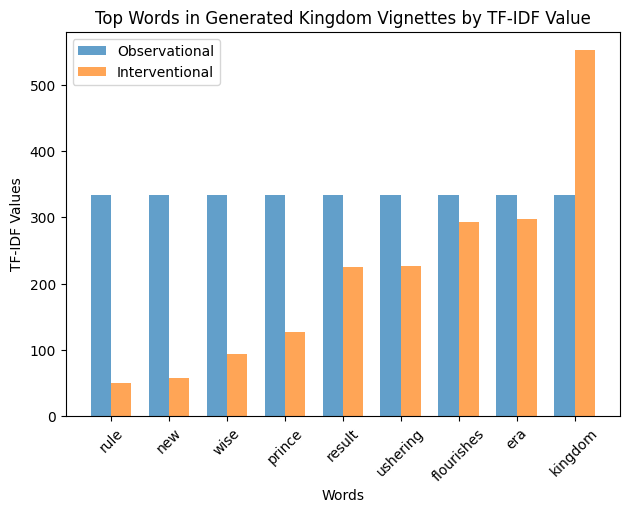

In [26]:
import matplotlib.pyplot as plt

labels = [feature_names[i] for i in combined_indices]    #A
labels, indices = np.unique(labels, return_index=True)    #A
obs_values = np.array(X_obs.sum(axis=0))[0, combined_indices]    #A
int_values = np.array(X_int.sum(axis=0))[0, combined_indices]    #A
obs_values = [obs_values[0][i] for i in indices]    #A
int_values = [int_values[0][i] for i in indices]    #A
combined = list(zip(labels, obs_values, int_values))    #A
sorted_combined = sorted(combined, key=lambda x: (-x[1], x[2]))    #A
labels, obs_values, int_values = zip(*sorted_combined)    #A

width = 0.35    #B
x = np.arange(len(labels))    #B
fig, ax = plt.subplots()    #B
rects1 = ax.bar(x - width/2, obs_values, width, label='Observational', alpha=0.7)    #B
rects2 = ax.bar(x + width/2, int_values, width, label='Interventional', alpha=0.7)    #B
ax.set_xlabel('Words')    #B
ax.set_ylabel('TF-IDF Values')    #B
ax.set_title('Top Words in Generated Kingdom Vignettes by TF-IDF Value')    #B
ax.set_xticks(x)    #B
ax.set_xticklabels(labels)    #B
ax.legend()    #B
fig.tight_layout()    #B
plt.xticks(rotation=45)    #B
plt.show()    #B
#A Prepare data for the bar plot.
#B Produce the plot.
